**Possibilitando acesso a drive**

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

**Importando bibliotecas**

In [3]:
import os 
import time
import numpy as np 
import cv2 
import torchvision.models.segmentation 
import torch 
import torchvision.transforms as tf
from PIL import Image
import matplotlib.pyplot as plt
#import segmentation_models_pytorch as smp
import torch.nn as nn
import time
import pandas as pd
import random
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Segmentation Model
#from torchvision.io.image import read_image
#from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
#from torchvision.transforms.functional import to_pil_image

# Função de Recall
from sklearn.metrics import recall_score
# Função de F1
from sklearn.metrics import f1_score
# Função de Precision
from sklearn.metrics import precision_score
# Função de Accuracy
from sklearn.metrics import accuracy_score

**Inicializando constantes**

In [4]:
model_name = 'MOBILENET_V3_LARGE'
model_folder = f'/content/drive/MyDrive/DEV/saved-weights/{model_name}/'

ImagesFolder="/content/drive/MyDrive/DEV/corte2/" # ALTERAR ESSE CAMINHO PARA A PASTA CORTE 2 NA NUVEM COM GPUb

In [5]:
n_epochs = 100
batchSize = 2 # Esse valor precisa ser divisor do número de imagens no treino
batchSize_val = 2 # Esse valor precisa ser divisor do número de imagens na validação
Learning_Rate = 1e-5

**Carregando arquivo com dataframe do dataset "aleatoriezado"**

In [6]:
# Carregando dataframe de um arquivo chamado "all_dataset_dataframe.csv"
# Referencia https://towardsdatascience.com/how-to-read-csv-file-using-pandas-ab1f5e7e7b58
df = pd.read_csv(f'{ImagesFolder}all_dataset_dataframe.csv') # ALTERAR ESSE CAMINHO PARA A LOCALIZAÇÃO DO DATAFRAME NA NUVEM COM GPU
df['Status'].value_counts()


Train    640
Test      78
Val       78
Name: Status, dtype: int64

**Lendo valores de desvio padrão e média de um arquivo**

In [7]:
# Lendo a média e desvio padrão do arquivo "mean_and_std_list.txt"
mean_and_std_list_file = open(f"{ImagesFolder}mean_and_std.txt", "r")
content_list = mean_and_std_list_file.readlines()

mean = [float(integer) for integer in content_list[1].split(' ')[0:3]]
std = [float(integer) for integer in content_list[3].split(' ')[0:3]]

print(mean)
print(std)

[0.6604449458815983, 0.6988043731738397, 0.6452534234104293]
[0.1753238443181036, 0.19331901534376825, 0.1546044630633522]


**Declaração do Dataset pelo Pytorch**

In [8]:
# Referência: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
class CustomImageDataset(Dataset):
    
  def __init__(self, df):
    self.dataframe = df
    #----------------------------------------------Funções de transformação-------------------------------------------------------------------#
    self.transformImg=tf.Compose([tf.ToPILImage(), tf.ToTensor(),tf.Normalize((mean[0], mean[1], mean[2]), (std[0], std[1], std[2]))])
    self.transformMask=tf.Compose([tf.ToPILImage(), tf.ToTensor()])

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    pair_path = os.path.join(ImagesFolder,  self.dataframe.iloc[idx].Path)
    Img = cv2.imread(os.path.join(pair_path, "img.png"))
    Label = cv2.imread(os.path.join(pair_path, "label.png"),0)

    mask = np.zeros(Img.shape[0:2],np.float32)
    mask[Label != 0] = 1 # set to 1 only the pixels that corresponds to the mask

    image = self.transformImg(Img)
    label = self.transformMask(mask)
    return image, label

In [9]:
ds_train=CustomImageDataset(df[df['Status'] == 'Train'])
ds_val=CustomImageDataset(df[df['Status'] == 'Val'])

In [10]:
print(len(ds_train))
print(len(ds_val))

640
78


**Instanciação do DataLoader's pelo Pytorch**

In [11]:
train_dataloader = DataLoader(ds_train, batch_size=batchSize, shuffle=True, num_workers=2)
val_dataloader = DataLoader(ds_val, batch_size=batchSize_val, shuffle=True, num_workers=2)

# MODEL



In [12]:
Net = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True) # Load net
Net.classifier[4] = torch.nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1)) # Change final layer to 3 classes

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth


  0%|          | 0.00/42.3M [00:00<?, ?B/s]

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
Net=Net.to(device)
optimizer=torch.optim.Adam(params=Net.parameters(),lr=Learning_Rate) # Create adam optimizer

**Treinamento**

In [14]:
epoch = []

train_loss = []
train_loss_sum = 0

val_loss = []
val_loss_sum = 0

cont2 = 0

val_metrics = {'accuracy': [], 'precision_macro' : [], 'precision_micro' : [], 'recall' : [], 
               'f1_macro' : [], 'f1_micro' : [], 'training_loss' : [], 'validation_loss' : []}
loss_dict = {'training' : [], 'validation' : []} 

train_prev_loss = float('-inf')
train_best_loss = float('inf')
train_last_improvement = 0


val_prev_loss = float('-inf')
val_best_loss = float('inf')
val_last_improvement = 0

patience_n_iterations = 5
patience_min_threshold = 0.01


#Net.load_state_dict(torch.load("0.torch")) # Load trained model
start = time.time()
for itr in range(n_epochs): # Training loop
  print(f'training epoch: {itr}')
  batch_it = 0
  train_loss_sum = 0
  
  #TRAINING
  Net.train()
  for images, mask in train_dataloader:
    Net.zero_grad()
    
    # Iterar sobre o dataloader do treino    
    mask = mask.squeeze()
    images = torch.autograd.Variable(images,requires_grad=False).to(device) # Load image
    mask = torch.autograd.Variable(mask, requires_grad=False).to(device) # Load annotation
    
    Pred=Net(images)['out'] # make prediction
    
    criterion = torch.nn.CrossEntropyLoss() # Set loss function
    
    Loss = criterion(Pred,mask.long()) # Calculate cross entropy loss    
    Loss.backward() # Backpropogate loss
    optimizer.step() # Apply gradient descent change to weight
    
    #print(f'Training Batch Iteration = {batch_it}, Training Loss = {Loss.data.cpu().numpy()}')
    train_loss_sum += Loss.data.cpu().numpy()
    batch_it += 1
    
  delta = 1 - train_loss_sum / train_prev_loss
  if(delta >= patience_min_threshold):
    train_prev_loss = train_loss_sum
    train_last_improvement = 0  
  else:
    train_last_improvement += 1
    if train_last_improvement >= patience_n_iterations:
        break
  
  train_loss.append(train_loss_sum/len(train_dataloader))

  #VALIDATION 
  val_loss_sum = 0

  Net.eval()
  with torch.no_grad():
        
    for images, mask in val_dataloader:
        
      mask = mask.squeeze()
      AnnMap = np.zeros(mask.shape,np.float32)
      AnnMap[mask != 0] = 1 # set to 1 only the pixels that corresponds to the mask
    
      images = torch.autograd.Variable(images,requires_grad=False).to(device) # Load image
      mask = torch.autograd.Variable(mask, requires_grad=False).to(device) # Load annotation
    
      Pred = Net(images)['out'] # make prediction     

      criterion = torch.nn.CrossEntropyLoss() # Set loss function
      Loss=criterion(Pred,mask.long()) # Calculate cross entropy loss      
    
      val_loss_sum += Loss.data.cpu().numpy()
      cont2+=1


  delta = 1 - val_loss_sum / val_prev_loss
  if(delta >= patience_min_threshold):
    val_prev_loss = val_loss_sum
    val_last_improvement = 0  
  else:
    val_last_improvement += 1
    if val_last_improvement >= patience_n_iterations:
        break  

  if(val_loss_sum < val_best_loss ):
    val_best_loss  = val_loss_sum
    model_weight_name = f'{model_name}_best_{Learning_Rate}'
    torch.save(Net.state_dict(), f"{model_folder}{model_weight_name}.torch") 
  
  val_loss.append(val_loss_sum/len(val_dataloader))

  # Salvando perdas em dataframe
  loss_dict['training'].append(train_loss_sum)
  loss_dict['validation'].append(val_loss_sum)

  # Salvando pesos
  model_weight_name = f'{model_name}_{Learning_Rate}'  
  torch.save(Net.state_dict(), f"{model_folder}{model_weight_name}.torch") 

  print(f'it = {itr}, training_loss = {train_loss_sum}, val_loss = {val_loss_sum}, delta =  {delta}')
# ---- FINALIZANDO TREINO ----- #
end = time.time()

training epoch: 0
it = 0, training_loss = 132.42273113131523, val_loss = 8.59610941261053, delta =  1.0
training epoch: 1
it = 1, training_loss = 46.659806095063686, val_loss = 5.093841060996056, delta =  0.40742482249895884
training epoch: 2
it = 2, training_loss = 33.62512049078941, val_loss = 3.9468337446451187, delta =  0.2251753249887718
training epoch: 3
it = 3, training_loss = 26.00225780531764, val_loss = 3.232054367661476, delta =  0.18110197267706607
training epoch: 4
it = 4, training_loss = 21.04152050241828, val_loss = 2.574558086693287, delta =  0.20342983321902308
training epoch: 5
it = 5, training_loss = 17.37377967312932, val_loss = 2.1873444616794586, delta =  0.15040003448170713
training epoch: 6
it = 6, training_loss = 14.778932120651007, val_loss = 1.9116455912590027, delta =  0.12604273138066802
training epoch: 7
it = 7, training_loss = 12.802122917026281, val_loss = 1.7087589707225561, delta =  0.10613192187095
training epoch: 8
it = 8, training_loss = 11.17777161

00:42:05 com 100 épocas


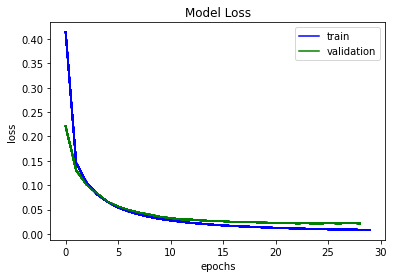

In [15]:
# Salvando dataframe de métricas
df_metrics = pd.DataFrame(val_metrics)
df_metrics.to_csv('dataframe_metrics.csv', index=False)

# Duração do treino e validação
trainingDuration = time.strftime("%H:%M:%S", time.gmtime((end-start)))
print(f"{trainingDuration} com {n_epochs} épocas")

# Plot de gráfico loss do treino por épocas de treinamento
plt.title("Model Loss")
plt.xlabel("epochs")
plt.ylabel("loss")

for i in range(n_epochs):
  plt.plot(train_loss, color="b", label="train")
  plt.plot(val_loss, color="g", label="validation")
  plt.legend(["train","validation"])

# TESTING

In [16]:
model_path = f'{model_folder}{model_name}_best_{Learning_Rate}.torch'

Net = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True) # Load net
Net.classifier[4] = torch.nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1)) # Change final layer to 3 classes

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
Net = Net.to(device)  # Set net to GPU or CPU
Net.load_state_dict(torch.load(model_path,  map_location=device)) # Load trained model
Net.eval() # Set to evaluation mode

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride

In [17]:
test_dataloader = DataLoader(CustomImageDataset(df[df['Status'] == 'Test']), batch_size=1, shuffle=False)

In [18]:
test_metrics = {'accuracy': [], 'precision_macro' : [], 'precision_micro' : [], 'recall' : [], 
               'f1_macro' : [], 'f1_micro' : []}

In [19]:
Net.eval()
with torch.no_grad():
  # Iterar sobre o dataloader da validação, configurar o batchsize por questões de memória
  for images, mask in test_dataloader:
    
    mask = mask.squeeze()
    AnnMap = np.zeros(mask.shape,np.float32)
    AnnMap[mask != 0] = 1 # set to 1 only the pixels that corresponds to the mask
  
    images = torch.autograd.Variable(images,requires_grad=False).to(device) # Load image
    mask = torch.autograd.Variable(mask, requires_grad=False).to(device) # Load annotation
    #print(mask.shape)
    Pred = Net(images)['out'] # make prediction

    # ---- CALCULANDO MÉTRICAS ----- #
    seg = torch.argmax(Pred,1).cpu().detach().numpy()  # Get  prediction classes
  
    # Accuracy
    accuracy = accuracy_score(AnnMap.flatten(), seg.flatten())
    # Precision
    precision_macro = precision_score(AnnMap.flatten(), seg.flatten(), average='macro')
    precision_micro = precision_score(AnnMap.flatten(), seg.flatten(), average='micro')
    # Recall:    
    recall = recall_score(AnnMap.flatten(), seg.flatten())
    # F1
    f1_macro = f1_score(AnnMap.flatten(), seg.flatten(), average='macro')
    f1_micro = f1_score(AnnMap.flatten(), seg.flatten(), average='micro')    
    
    # #print(f'Accuracy: {accuracy}, Precision_macro: {precision_macro}, Precision_micro: {precision_micro}, F1_macro: {f1_macro}, F1_micro: {f1_micro}, Recall: {recall}')


    test_metrics['accuracy'].append(accuracy)
    test_metrics['recall'].append(recall)
    test_metrics['precision_macro'].append(precision_macro)
    test_metrics['precision_micro'].append(precision_micro)      
    test_metrics['f1_macro'].append(f1_macro)
    test_metrics['f1_micro'].append(f1_micro)

In [20]:
test_results = pd.DataFrame(test_metrics)

In [21]:
test_results.mean(axis=0)

accuracy           0.993759
precision_macro    0.978002
precision_micro    0.993759
recall             0.968126
f1_macro           0.979923
f1_micro           0.993759
dtype: float64